# Capitulo 10 - Aprendizado Profundo para Séries Temporais

In [1]:
import keras  
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

* Não se exige estacionaridade.
* Desaparee a necessidade de desevolver uma hipotese sobre a dinamica subjacente do sistema.

> Apesar de não exigir estacionariedade , na pratica, não se ajustam bem a dados com tedencias

### Construindo um pipeline de treinamento

In [2]:
data = pd.read_csv('dataset/electricity.txt', sep=',', header=None, names=list(range(1, 322)))

In [3]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,312,313,314,315,316,317,318,319,320,321
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [4]:
data.shape

(26304, 321)

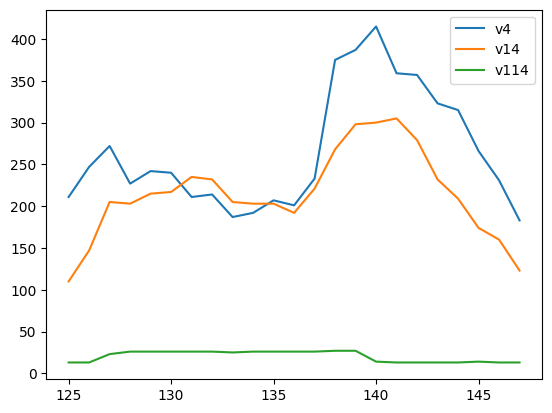

In [5]:
plt.plot(data.iloc[125:148, 4], label='v4')
plt.plot(data.iloc[125:148, 14], label='v14')
plt.plot(data.iloc[125:148, 114], label='v114')
plt.legend()
plt.show()

> Como se trata de dados por hora, plotamos 24 pontos de dados , assim temos o valor de um dia interio de dados, acima

plotando a semana

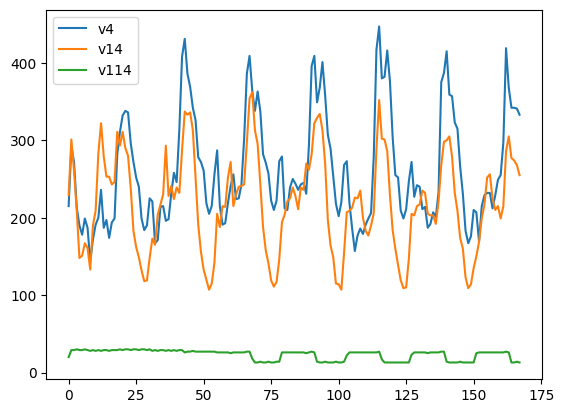

In [6]:
plt.plot(data.iloc[:24*7, 4], label='v4')
plt.plot(data.iloc[:24*7, 14], label='v14')
plt.plot(data.iloc[:24*7, 114], label='v114')
plt.legend()
plt.show()

Ainda que pudessemos predizer os valores absolutos dos dados como nossa tecnica de previsão, isso ja foi feito em artigos academicos e postagens de blogs.
Em vez disso, vamos predizer a diferença dos dados... Predizer a diferença em vez dos valores totais de uma série temporal costuma ser desafiafor pq os dados são mais ruidosos.

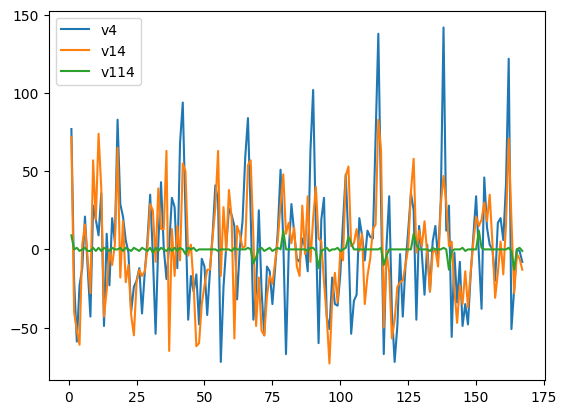

In [7]:
plt.plot(data.iloc[:24*7, 4].diff(), label='v4')
plt.plot(data.iloc[:24*7, 14].diff(), label='v14')
plt.plot(data.iloc[:24*7, 114].diff(), label='v114')
plt.legend()
plt.show()

In [8]:
data.diff().to_csv('dataset/electricity_diff.txt', sep=',', index=False)

> Se fossemos excutar modelos tradicionais, modelo de ml **séria necessario fazer uma boa analise desses pontos para examinar as correlações entre diferentes locais consumidosres de energia eletrica no conj. de dados**
> Avaliar a estacionariedade se houve desvio ao longo do tempo no dados.

> **É necessario fazer essa coisa no aprendizdo profundo, de modo voce consiga avaliar os modelos apropriados para o conj de dados e também determinar as expectivativas**

### Etapas de uma pipeline de treinamento

* Facilitação a parimetrizacao do codigo
* Extração dos dados para memoria e o devido pre-processamento
* Modelagem adequada dos dados no formato esperado
* Criação do grafo que usa esse iteradores para saber qual formato de dados esperar.
* definir parametros do modelo
* estabelecimento de uma tipo de sistema de registro de dados para seus peso e para seus resultados de epoca para epoca

In [9]:
#%%writefile capitulo_10.py
from math import floor 

# para arquivamento
import os 
import argparse

# modelo profundo

import keras 

# para processamento
import numpy as np 
import pandas as pd 

## relatorio cunstomizado
import perf_tool

## alguns hiperparemtros que não ajustamos por meio da entradas de linhas de comando

DATA_SEGMENT = {
    'tr' : 0.6,  "va": 0.2, 'tst':0.2
}

THRESHOLD_EPOCHS = 5
THRESHOLD_COR    = 0.0005


## Definindo parser

parser = argparse.ArgumentParser()


## Data shaping

### janela
parser.add_argument('--win', type=int, default=24*7)
parser.add_argument('--h', type=int, default=3)

## Especificação do modelo 
parser.add_argument('--model', type=str, default='rnn_model')

### conponent da CNN
parser.add_argument('--sz-filt', type=str, default=8)
parser.add_argument('--n-filt', type=int, default=10)

### conponent da RNN
parser.add_argument('--rnn-units',  type=int, default=10)

## Detalhes do treinamento

parser.add_argument('--n_batch', type=int, default=1024)
parser.add_argument('--learning_rate', type=float, default=0.0001)
parser.add_argument('--n_epochs', type=float, default=30)
parser.add_argument('--drop', type=float, default=0.2)

## Repositorio
parser.add_argument('--data-dir', type=str, default='../models')
parser.add_argument('--save-dir', type=str, default=None)


_StoreAction(option_strings=['--save-dir'], dest='save_dir', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

### Preparando nossos dados de entrada

#### Data shaping


 🔹 `nt`

* Representa o **número de passos de tempo** (*number of timesteps*) que a RNN vai olhar de uma vez.
* Também chamado de **janela temporal**.
* Exemplo:

  * Se você tem uma série diária e define `nt = 10`, a RNN recebe **10 dias passados** como entrada para prever o próximo.
  * É a dimensão da sequência no eixo do tempo.

---

🔹 `ntc`

* Representa o **formato de entrada** da RNN:

  * **n** → número de amostras (*batch size*)
  * **t** → número de passos de tempo (*timesteps*)
  * **c** → número de características (*features*) por passo

Ou seja, **`(n, t, c)` = (amostras, timesteps, features)**.

Exemplo:

* Você tem 1000 amostras (n = 1000),
* Cada amostra é uma sequência de 10 dias (t = 10),
* Cada dia tem 3 variáveis (c = 3, por ex. temperatura, pressão e umidade).

A entrada para a RNN será **`ntc = (1000, 10, 3)`**.


> Nenhuma dessas representações tem acuracia maior do que a outra,

In [ ]:
def prepare_data(data_dir, win, h, model_name='fc_model', num_features=321):
    data = pd.read_csv(
        os.path.join(data_dir, 'electricity_diff.txt'), sep=',').dropna()
    
    x = data.values.astype('float32')
    x = x[:, :num_features+1]
    # Normalizando os dados
    x = (x - np.mean(x, axis=0, dtype=np.float32)) / np.std(x, axis=0, dtype=np.float32)

    if model_name == 'fc_model': ## NC data
        X = np.hstack([x[1:-h], x[0:-(h+1)]], dtype=np.float32)
        y = x[h:]

        return X, y
    else: ## TNC data
        X = np.zeros((x.shape[0] - win - h, win, x.shape[1]),  dtype=np.float32)
        y = np.zeros((x.shape[0] - win - h, x.shape[1]),  dtype=np.float32)

        for i in range(win, x.shape[0] - h):
            X[i-win] = x[(i - win):i, :]   # janela de tamanho 'win'
            y[i-win] = x[i + h - 1, :]     # target deslocado por h

        return X, y

In [ ]:
def prepare_iter(X, y, DATA_SEGMENT=0.2):


    n_train = int(y.shape[0] * DATA_SEGMENT['tr'])
    n_validation = int(y.shape[0] * DATA_SEGMENT['va'])

    xtrain, xvalid, xtest = (
        X[:n_train],
        X[n_train:n_train + n_validation],
        X[n_train + n_validation:]
    )

    ytrain, yvalid, ytest = (
        y[:n_train],
        y[n_train:n_train + n_validation],
        y[n_train + n_validation:]
    )

    return (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest)

In [12]:
X, y = prepare_data('dataset', 24*7, 3, num_features=4)

In [15]:
(xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = prepare_iter(X, y)

#### Definindo parametro

### Reder neural simples

In [16]:
def rna_model(input_shape, output_shape):
    return keras.models.Sequential([
        keras.layers.Flatten(input_shape=(input_shape)),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(output_shape)
    ])

In [17]:
def fit_(model, xtrain, ytrain, xvalid, yvalid, n_epochs=30):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
        loss='mse'
    )
    history = model.fit(
        xtrain, ytrain, 
        epochs=n_epochs, 
        validation_data=(xvalid, yvalid)
    )

    return history, model

### Mecanimos de atenção

Atençao é a ideia de uma arquiterura de rede neural forneça uma meacanimos para um modelo aprender quais informações são importatntes e quando. isso é feito por meio de pesos de atenção,ajustados a cada intervalo de tempo com um objetivo de ser o modelo aprenda combinar informações de diferentes intervalos.

## CNN

Uso :
* Estabelecer um impressão digital para o historio de navegação  de uma usuario na internt, o que ajuda a detectar atividades de navegação
* Gerar predição de trafec com base nos registros anteriores de varios lovais em um grande cidade

### Rede convolucional simples

In [18]:
X, y = prepare_data('dataset', 24*7, 3,'a', num_features=4)

(xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = prepare_iter(X, y)

In [23]:
def cnn_model(input_shape, output_shape):
    return keras.models.Sequential([
        keras.layers.Conv1D(10, 3, activation='relu', input_shape=input_shape),
        keras.layers.GlobalAvgPool1D(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(output_shape)
    ])

In [24]:
xtrain.shape

(15679, 168, 5)

In [25]:
cnn_simples = cnn_model(xtrain.shape[1:], 5)
cnn_simples.summary()

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 166, 10)        │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 10)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485 (1.89 KB)

 Trainable params: 485 (1.89 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history, model = fit_(cnn_simples, xtrain, ytrain, xvalid, yvalid, n_epochs=10)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2414 - val_loss: 0.7692
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1944 - val_loss: 0.7646
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1887 - val_loss: 0.7644
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1856 - val_loss: 0.7643
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1854 - val_loss: 0.7641
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1826 - val_loss: 0.7637
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1832 - val_loss: 0.7635
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1827 - val_loss: 0.7634
Epoch 9/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1811 - val_loss: 0.7633
Epoch 10/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1809 - val_loss: 0.7632


<Axes: >

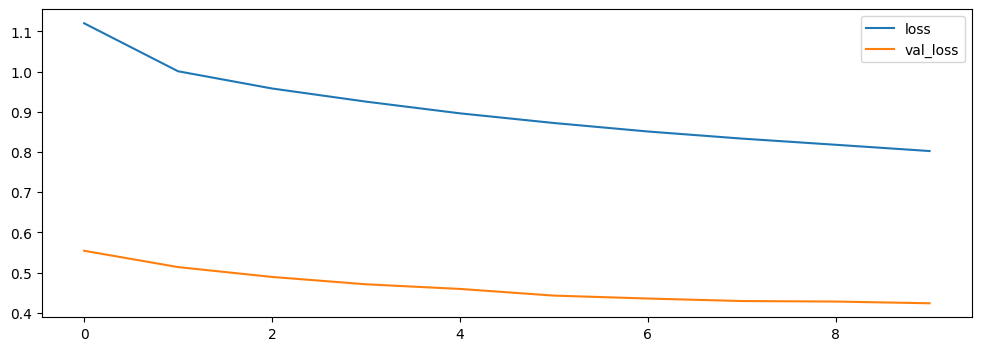

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 4))

In [ ]:
pred = model.predict(xtest)

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


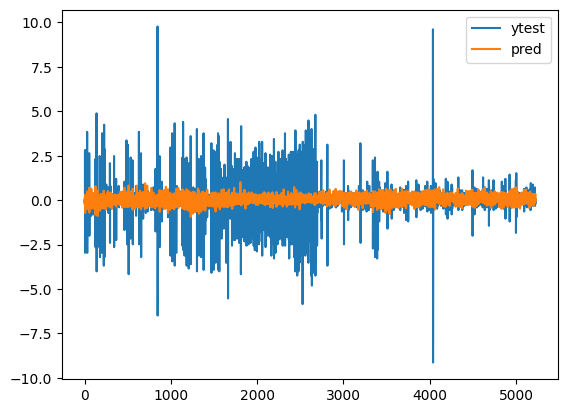

In [ ]:
plt.plot(ytest[:,0], label='ytest')
plt.plot(pred[:,0], label='pred')
plt.legend()

### Convoluciionais alternativos

#### Wavenet

2016, Aaron van e outros pesquisadores apresentaram uma arquitetura chamada WaveNet. Eles empilharam camada convolucionais 1D que dobrando de taxa de dilatação em cada camada: A primeira camada tem um vislumbre de somente 2 dois intervalos de tempo por vez, enquanto a proxima camda tem contato a proxima, a ve a proxima ve oitro intervalos de tempo e assim por diante.

In [44]:
wavenet = keras.models.Sequential()

# Input layer 
wavenet.add(keras.layers.InputLayer(input_shape=[None, 5]))

# 
for rate in (1, 2, 4, 8) * 2:
    wavenet.add(
        keras.layers.Conv1D(
            filters=20,
            kernel_size=2,
            padding='causal',
            activation='relu',
            dilation_rate=rate
        )
    )
wavenet.add(
    keras.layers.Conv1D(
        filters=5, #
        kernel_size=1,
    )
)
wavenet.add(keras.layers.Lambda(lambda x: x[:, -1, :]))

In [47]:
xtrain.shape, ytrain.shape

((15679, 168, 5), (15679, 5))

In [46]:
wavenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='mse'
)

history = wavenet.fit(
    xtrain, ytrain, 
    epochs=10, 
    validation_data=(xtest, ytest)
)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 1.1696 - val_loss: 0.6039
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.0860 - val_loss: 0.5152
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 1.0039 - val_loss: 0.4728
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.9689 - val_loss: 0.4544
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.9500 - val_loss: 0.4447
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.9382 - val_loss: 0.4368
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.9286 - val_loss: 0.4298
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.9200 - val_loss: 0.4242
Epoch 9/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - loss: 0.9127 - val_loss: 0.4202
Epoch 10/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 0.9048 - val_loss: 0.4140


In [48]:
pred = wavenet.predict(xtest)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [54]:
ytrain_real = np.cumsum(ytrain, axis=0) 
ytest_real = np.cumsum(ytest, axis=0)

#### Usando Camadas convolucionais 1d para processar seguencias


In [63]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=2, strides=2, padding='valid', input_shape=(None, 5)),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20),
    keras.layers.Dense(5)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss='mse'
)

history = model.fit(
    xtrain, ytrain, 
    epochs=1, 
    validation_data=(xtest, ytest)
)

490/490 ━━━━━━━━━━━━━━━━━━━━ 59s 102ms/step - loss: 1.0441 - val_loss: 0.4933


In [65]:
pred = model.predict(xtest)

164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step


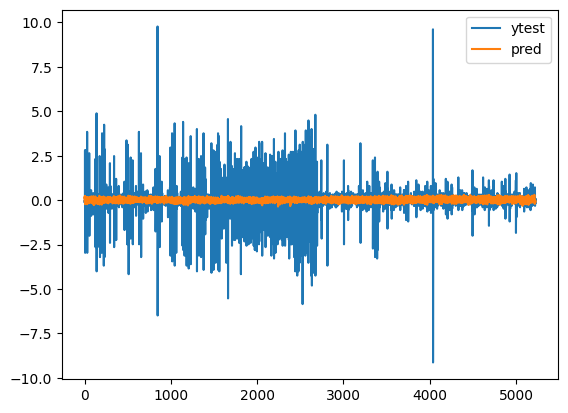

In [66]:
plt.plot(ytest[:,0], label='ytest')
plt.plot(pred[:,0], label='pred')
plt.legend()

Quando pode ser útil usar diff no Deep Learning?

Se sua série tem um forte crescimento exponencial ou tendência muito dominante, o modelo pode ter dificuldade.

Nesses casos, você pode usar:

* diff() para forçar estacionariedade;
* transformações logarítmicas ou normalizações (muito comum em deep learning)
* normalização por z-score ou min-max.>

In [4]:
def prepare_data(data, win, h, model_name='fc_model', num_features=321):
    
    x = data.values.astype('float32')
    x = x[:, :num_features+1]
    # Normalizando os dados
    x = (x - np.mean(x, axis=0, dtype=np.float32)) / np.std(x, axis=0, dtype=np.float32)

    if model_name == 'fc_model': ## NC data
        X = np.hstack([x[1:-h], x[0:-(h+1)]], dtype=np.float32)
        y = x[h:]

        return X, y
    else: ## TNC data
        X = np.zeros((x.shape[0] - win - h, win, x.shape[1]),  dtype=np.float32)
        y = np.zeros((x.shape[0] - win - h, x.shape[1]),  dtype=np.float32)

        for i in range(win, x.shape[0] - h):
            X[i-win] = x[(i - win):i, :]   # janela de tamanho 'win'
            y[i-win] = x[i + h - 1, :]     # target deslocado por h

        return X, y

In [5]:
def prepare_iter(X, y, DATA_SEGMENT=0.2):


    n_train = int(y.shape[0] * DATA_SEGMENT)

    xtrain, xtest = (
        X[:n_train],
        X[n_train:]
    )

    ytrain, ytest = (
        y[:n_train],
        y[n_train:]
    )

    return (xtrain, ytrain), (xtest, ytest)

In [6]:
data = pd.read_csv('dataset/electricity.txt', sep=',', header=None, names=list(range(1, 322)))

In [7]:
data = data.loc[:, 1:5]
data.head()

,1,2,3,4,5
0,14.0,69.0,234.0,415.0,215.0
1,18.0,92.0,312.0,556.0,292.0
2,21.0,96.0,312.0,560.0,272.0
3,20.0,92.0,312.0,443.0,213.0
4,22.0,91.0,312.0,346.0,190.0


In [8]:
X, y = prepare_data(data, 24*7, 3,'a',num_features=5)

In [9]:
(xtrain, ytrain), (xtest, ytest) = prepare_iter(X, y, DATA_SEGMENT=0.2)

In [10]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler(feature_range=(-1, 1))

for i in range(xtrain.shape[2]):
    xtrain[:, :, i] = min_max.fit_transform(xtrain[:, :, i])
    xtest[:, :, i] = min_max.transform(xtest[:, :, i])

for i in range(ytrain.shape[1]):
    ytrain[:, i] = min_max.fit_transform(ytrain[:, i].reshape(-1, 1)).ravel()
    ytest[:, i] = min_max.transform(ytest[:, i].reshape(-1, 1)).ravel()

## GRU

Mais rapido que o LTSM , contudo, não se sobressai na maioria dos caso

In [13]:
def last_metric(y_true, y_pred):
    return keras.metrics.mean_absolute_error(y_true[:, -1], y_pred[:, -1])

In [48]:
xtrain.shape, ytrain.shape

((5226, 168, 5), (5226, 5))

In [49]:
model_GRU = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, recurrent_dropout=0.01),
    keras.layers.Dense(5)
])

model_GRU.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss='mse',
    metrics=[last_metric]
)

history = model_GRU.fit(
    xtrain, ytrain, 
    epochs=10, 
    validation_data=(xtest, ytest)
)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 86s 480ms/step - last_metric: 0.1977 - loss: 0.0872 - val_last_metric: 0.1956 - val_loss: 0.0466
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 89s 542ms/step - last_metric: 0.1625 - loss: 0.0550 - val_last_metric: 0.1815 - val_loss: 0.0496
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 537ms/step - last_metric: 0.1454 - loss: 0.0489 - val_last_metric: 0.1608 - val_loss: 0.0387
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 88s 538ms/step - last_metric: 0.1388 - loss: 0.0459 - val_last_metric: 0.1443 - val_loss: 0.0386
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 92s 565ms/step - last_metric: 0.1322 - loss: 0.0438 - val_last_metric: 0.1389 - val_loss: 0.0380
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 89s 546ms/step - last_metric: 0.1257 - loss: 0.0418 - val_last_metric: 0.1504 - val_loss: 0.0411
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - last_metric: 0.1199 - loss: 0.0405 - val_last_metric: 0.1284 - val_loss: 0.0356
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8

164/164 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step


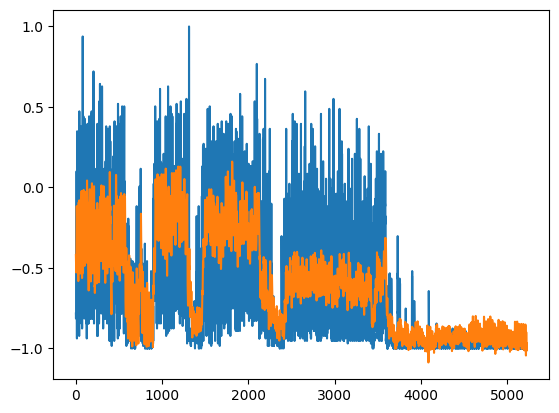

In [50]:
plt.plot(ytrain[:, 0,])
plt.plot(model_GRU.predict(xtrain)[:, 0])
plt.show()

### LTSM

In [14]:
model_LSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20, recurrent_dropout=0.01),
    keras.layers.Dense(5)
])

model_LSTM.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss='mse',
    metrics=[last_metric]
)

history = model_LSTM.fit(
    xtrain, ytrain, 
    epochs=10, 
    validation_data=(xtest, ytest)
)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 457ms/step - last_metric: 0.2139 - loss: 0.0893 - val_last_metric: 0.1865 - val_loss: 0.0528
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 80s 490ms/step - last_metric: 0.1744 - loss: 0.0586 - val_last_metric: 0.1842 - val_loss: 0.0460
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - last_metric: 0.1534 - loss: 0.0509 - val_last_metric: 0.1475 - val_loss: 0.0345
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - last_metric: 0.1296 - loss: 0.0436 - val_last_metric: 0.1327 - val_loss: 0.0321
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 78s 477ms/step - last_metric: 0.1162 - loss: 0.0398 - val_last_metric: 0.1243 - val_loss: 0.0267
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - last_metric: 0.1095 - loss: 0.0378 - val_last_metric: 0.1117 - val_loss: 0.0258
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 50s 308ms/step - last_metric: 0.1032 - loss: 0.0359 - val_last_metric: 0.1171 - val_loss: 0.0240
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8

164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step


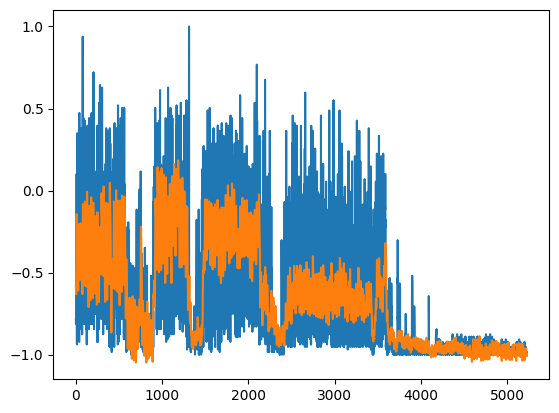

In [15]:
plt.plot(ytrain[:, 0,])
plt.plot(model_LSTM.predict(xtrain)[:, 0])
plt.show()